In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
import matplotlib.pyplot as plt

## Importar modelo/s

In [2]:
with open('models/model_enfermeras.pkl','rb') as f:
    modelo_enfermeria_arima=pickle.load(f)

In [3]:
with open('models/model_enfermeras_plantilla.pkl','rb') as f:
    modelo_plantilla_profet=pickle.load(f)

In [4]:
with open('models/model_enfermeras_google.pkl','rb') as f:
    modelo_google_arima=pickle.load(f)

In [5]:
#Importamos dataset
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")
ts=df.set_index('date').drop(['index','COLECTIVO','mes','año','casos_covid','cambio_normativa'],axis=1)

In [6]:
ts

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google
date,,,,
2003-01-01,2,861.654839,58.322581,16.799731
2003-02-01,1,847.775357,63.000000,29.345238
2003-03-01,0,857.704194,69.477419,17.731183
2003-04-01,2,869.806667,70.153333,11.233333
2003-05-01,1,855.794839,61.032258,10.311828
...,...,...,...,...
2021-10-01,1,1417.836129,65.073548,60.000000
2021-11-01,1,1412.164000,65.600333,71.433333
2021-12-01,2,1411.344516,92.730645,65.709677


## Predicción valores exógenos

### Predicción plantilla

In [7]:

ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})
yhat=modelo_plantilla_profet.predict(ds).yhat
exogenos=pd.DataFrame(data=yhat.to_numpy(),index=ds['ds'],columns=['Plantilla'])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Predicción búsquedas google

In [8]:
histórico_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

In [9]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_google_arima.order 
sparams = modelo_google_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodelo_google_arima = SARIMAX(histórico_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results_google=smodelo_google_arima.fit(maxiter=100)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [10]:
y_pred_google=results_google.get_prediction(start='2022-03-01',end='2022-12-01').predicted_mean

In [11]:
exogenos['busquedas_google']=y_pred_google.to_numpy()

In [12]:
#exogeno_google=pd.DataFrame(data=y_pred_google.to_numpy(),index=ds['ds'],columns=['busquedas_google'])

### Festivos_intersemanales

In [13]:
festivos_intersemanales=[0,2,1,2,0,1,0,1,1,3]

In [14]:
exogenos['Festivos_intersemanales']=np.array(festivos_intersemanales)
#exogeno_fi=pd.DataFrame(data=np.array(festivos_intersemanales),index=ds['ds'],columns=['festivos_intersemanales'])

In [15]:
exogenos

,Plantilla,busquedas_google,Festivos_intersemanales
ds,,,
2022-03-01,1414.749051,23.291214,0
2022-04-01,1424.477187,25.367276,2
2022-05-01,1424.539009,24.563009,1
2022-06-01,1440.134477,22.715062,2
2022-07-01,1488.939250,26.101299,0
2022-08-01,1501.963484,24.707889,1
2022-09-01,1493.434563,28.016415,0
2022-10-01,1474.896910,45.128498,1
2022-11-01,1485.177965,44.728755,1


## Predicción valor objetivo

### Vuelvo a entrenar el modelo con valores históricos

In [16]:
ts

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google
date,,,,
2003-01-01,2,861.654839,58.322581,16.799731
2003-02-01,1,847.775357,63.000000,29.345238
2003-03-01,0,857.704194,69.477419,17.731183
2003-04-01,2,869.806667,70.153333,11.233333
2003-05-01,1,855.794839,61.032258,10.311828
...,...,...,...,...
2021-10-01,1,1417.836129,65.073548,60.000000
2021-11-01,1,1412.164000,65.600333,71.433333
2021-12-01,2,1411.344516,92.730645,65.709677


In [17]:
endogena_hist=ts[['Plantilla_de_baja']]
exogenas_hist=ts[['Plantilla','busquedas_google','Festivos_intersemanales']]

In [18]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_enfermeria_arima.order 
sparams = modelo_enfermeria_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel = SARIMAX(endogena_hist, 
                order=params,
                exog=exogenas_hist,
                seasonal_order=sparams, 
                freq='MS'
                )
results=smodel.fit(maxiter=1000)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Hago predicción a futuro

In [19]:
#Obtengo predicciónes y intervalos de confianza
y_pred_inf=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos)
y_pred_media=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos).predicted_mean
intervalos=y_pred_inf.conf_int()

In [20]:
from cycler import cycler
colors= cycler(color=['#44c5c8', '#67d1d3', '#8ddcde', '#baeaea', '#ebf9f9','#434343'])
plt.rcParams['axes.prop_cycle'] =colors

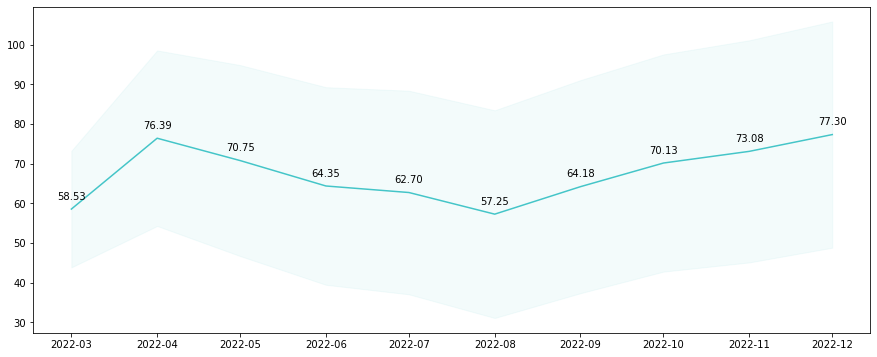

In [21]:
#Dibujo las resultados con intérvalo de confianza
plt.rcParams['figure.figsize']=(15,6)
ds=y_pred_media.reset_index()
#data
x = ds['index']
y = ds['predicted_mean']
#confidence interval
ci_low=intervalos['lower Plantilla_de_baja']
ci_upp=intervalos['upper Plantilla_de_baja']
fig, ax = plt.subplots()
ax.plot(x,y)
for i,j in zip(x,y):

    label = "{:.2f}".format(j)

    plt.annotate(label, # this is the text
                 (i,j), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center)
ax.fill_between(x, ci_low, ci_upp, color='#8ddcde', alpha=.1)

In [22]:
y_pred_media.sum()

674.6458313441874

In [23]:
intervalos

,lower Plantilla_de_baja,upper Plantilla_de_baja
2022-03-01,43.837506,73.212676
2022-04-01,54.266633,98.508757
2022-05-01,46.683989,94.820035
2022-06-01,39.443990,89.246825
2022-07-01,37.042704,88.355469
2022-08-01,31.077035,83.416333
2022-09-01,37.325826,91.026395
2022-10-01,42.764916,97.501494
2022-11-01,45.081066,101.070076
2022-12-01,48.795278,105.814660


## Obtener coste medio mensual por sustitución enfermera/o

In [24]:
#Valor de tabla retributiva 2022 para DUI de nivel 2:
#coste_mensual_bruto=1071.06+528.7+620.91+(781.15+528.7+620.91)/6
#No se tiene en cuenta importes de antiguedad como la carrera profesional y triennios ni atención continuada

In [25]:
coste_mensual_bruto=2513.58

In [26]:
inf=y_pred_media.to_frame(name='plantilla_it')

In [27]:
inf['coste_mensual']=inf*coste_mensual_bruto

In [28]:
inf

,plantilla_it,coste_mensual
2022-03-01,58.525091,147107.498207
2022-04-01,76.387695,192006.582259
2022-05-01,70.752012,177840.841298
2022-06-01,64.345407,161737.329328
2022-07-01,62.699087,157599.170300
2022-08-01,57.246684,143894.120274
2022-09-01,64.176110,161311.787496
2022-10-01,70.133205,176285.422384
2022-11-01,73.075571,183681.293221
2022-12-01,77.304969,194312.223983


## Calcular cobertura a partir de coste_medio_mensual, previsión de plantilla de baja y crédito presupuestario

In [29]:
inf_cobertura_total=inf['coste_mensual'].sum()

In [30]:
inf_cobertura_total

1695776.2687501225

In [31]:
#Credito inicial en bolsa de substituciones/eventuales para Hospital Germans Trias i Pujol 2022:
Importe_inicial=7879362.4+7930089.1
Exceso_permitido=12777320.97
credito_habilitado_2022=Importe_inicial+Exceso_permitido
credito_habilitado_2022

28586772.47

In [32]:
#Gasto acumulado en subtituciones/eventuales
#gasto_enero
#gasto_febrero
gasto_en_substituciones_event_acum=4194367.95
gasto_anual_en_programas=18320654.35-gasto_en_substituciones_event_acum


In [33]:

credito_disponible=credito_habilitado_2022-gasto_en_substituciones_event_acum-gasto_anual_en_programas

credito_disponible

10266118.119999997

In [34]:
credito_disponible_su=credito_disponible*2/3 #2 tercios se reserva para sustituciones, el resto para refuerzos
credito_disponible_su

6844078.746666665

In [35]:
#credito_disponible_su=credito_disponible*0.5 
#el resto va para programas (25%), cobertura vacaciones (13%) y refuerzos (12%)


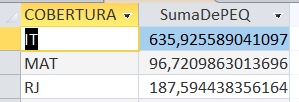

In [36]:
credito_disponible_su_it=credito_disponible_su*0.69
#el resto va para sustituciones de bajas maternales (10%) y reducciones de jornadas (21%)

In [37]:
credito_disponible_su_it_enfermeras=credito_disponible_su_it*0.40
#El 36% porque es la propoción media de personal enfermero de baja en el histórico

In [38]:
inf_cobertura_total

1695776.2687501225

In [39]:
credito_disponible_su_it_enfermeras

1888965.7340799996

In [40]:
Cobertura_permitida=credito_disponible_su_it_enfermeras/inf_cobertura_total
Cobertura_permitida

1.1139239113614132

In [41]:
f'Con el crédito disponible de {credito_disponible_su_it_enfermeras:3,.2f} € se pueden cubrir el {Cobertura_permitida:.0%} de las bajas por IT previstas hasta final de año'

'Con el crédito disponible de 1,888,965.73 € se pueden cubrir el 111% de las bajas por IT previstas hasta final de año'

In [42]:
#formula para saber la ampliación o reducción de crédito necesária para cubrir X% de bajas
def estado_credito_SU(cobertura_deseada):
    '''cobretura expresada en %'''
    credito_necesario=inf_cobertura_total*cobertura_deseada/100
    saldo=credito_disponible_su_it_enfermeras-credito_necesario
    if saldo>0:
        return f'Se estima que sobrará {saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'
    else:
        return f'Se estima que faltará {-saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'


In [43]:
estado_credito_SU(100)

'Se estima que sobrará 193,189.47 € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'